In [1]:
from fastai2.text.all import *
from fastai2.tabular.all import *
from lazylabel.text.all import *

In [2]:
source = Path('/home/lgvaz/.data/youtube_spam/')

In [3]:
fns = get_files(source, extensions='.csv')
dfs = fns.map(pd.read_csv)

In [4]:
df = pd.concat(dfs)
df['original'] = df['CONTENT'] # Hack for tokenizer cache
print(df.shape); df.head(2)

(1956, 6)


,COMMENT_ID,AUTHOR,DATE,CONTENT,CLASS,original
0,z12pgdhovmrktzm3i23es5d5junftft3f,lekanaVEVO1,2014-07-22T15:27:50,i love this so much. AND also I Generate Free Leads on Auto Pilot &amp; You Can Too! http://www.MyLeaderGate.com/moretraffic﻿,1,i love this so much. AND also I Generate Free Leads on Auto Pilot &amp; You Can Too! http://www.MyLeaderGate.com/moretraffic﻿
1,z13yx345uxepetggz04ci5rjcxeohzlrtf4,Pyunghee,2014-07-27T01:57:16,http://www.billboard.com/articles/columns/pop-shop/6174122/fan-army-face-off-round-3 Vote for SONES please....we're against vips....please help us.. &gt;.&lt;﻿,1,http://www.billboard.com/articles/columns/pop-shop/6174122/fan-army-face-off-round-3 Vote for SONES please....we're against vips....please help us.. &gt;.&lt;﻿


## Artificially divide into labelled an unlabelled df

In [5]:
splits = RandomSplitter(.1)(df)
df_lbl, df_ulbl = [df.iloc[i] for i in splits]
len(df_lbl), len(df_ulbl)

(1761, 195)

## Create labellers

In [6]:
ABSTAIN,SPAM,HAM = 'abstain','spam','ham'
vocab = CategoryMap([ABSTAIN,SPAM,HAM])

Splits and labels!

In [7]:
splits = RandomSplitter()(df_lbl)

In [8]:
cder,tkzer,nmzer = map(mk_transform, (ColReader('original'), Tokenizer.from_df('CONTENT'), Numericalize()))
x_tls = TfmdLists(df_lbl, [cder,tkzer,nmzer], splits=splits)

In [9]:
lbl_dict = {1:SPAM, 0:HAM}
y_tls = TfmdLists(df_lbl, [ColReader('CLASS'), lbl_dict.get, Categorize(vocab)], splits=splits)

In [10]:
dset = Datasets(tls=[x_tls, y_tls])

In [11]:
labeller = Labeller()

Helper function for keyword matches

In [12]:
def keyword_match(ws, label=SPAM):
    ws = L(ws)
    def _inner(x):
        for w in ws:
            if w in x: return label
        return ABSTAIN
    _inner.__name__ = f'kw_{ws[0]}'
    labeller.register_func(cder, _inner)

In [13]:
keyword_match('my')
keyword_match('subscribe')
keyword_match(['http', 'https'])
keyword_match(['please', 'plz', 'pliz'])
keyword_match(['song'], label=HAM)

In [14]:
@labeller(cder)
def regex_check(x):
    return SPAM if re.search(r'(check\s(my|this))|check\s(\w+)?\s?out', x, flags=re.I) else ABSTAIN

In [15]:
@labeller(tkzer)
def short_comment(x): return HAM if len(x) < 6 else ABSTAIN

TextBlob

In [16]:
from textblob import TextBlob
@labeller(cder, TextBlob)
def tb_polarity(x, tb):
    return HAM if tb.polarity > 0.9 else ABSTAIN
@labeller(cder, TextBlob)
def tb_sentiment(x, tb):
    return HAM if tb.subjectivity >= 0.5 else ABSTAIN

Spacy

In [17]:
import spacy
nlp = spacy.load('en_core_web_sm')
def spacy_doc(x): return nlp(str(x))

In [18]:
@labeller(cder, spacy_doc)
def has_person(x, sdoc):
    if len(sdoc) < 20 and any([ent.label_=='PERSON' for ent in sdoc.ents]):
        return HAM
    return ABSTAIN

In [19]:
tasks = tasks_labels(labeller, x_tls, vocab)
dset = Datasets(tls=[tasks, y_tls])
dls = dset.dataloaders()

In [20]:
labeller.summary(dls.train)

,Coverage,Polarity,Accuracy,Correct,Incorrect
kw_my,16.62% (234),1,0.867521,203,31
kw_subscribe,8.81% (124),1,0.983871,122,2
kw_http,9.52% (134),1,0.932836,125,9
kw_please,6.18% (87),1,1.000000,87,0
kw_song,14.28% (201),1,0.741294,149,52
regex_check,23.01% (324),1,1.000000,324,0
tb_polarity,4.69% (66),1,0.818182,54,12
tb_sentiment,37.22% (524),1,0.574427,301,223
has_person,5.54% (78),1,0.628205,49,29
short_comment,12.00% (169),1,0.852071,144,25


## Train models

Eliminate all 0s

In [21]:
def remove_items(l, items):
    for item in items:
        try: l.remove(item)
        except ValueError: pass

In [22]:
abstain_idx = y_tls.vocab.o2i[ABSTAIN]
abstain_idxs = [i for i,o in enumerate(dset.items) if all(o==abstain_idx)]
for split in dset.splits: remove_items(split, abstain_idxs)

### Sklearn

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder

In [24]:
x,y = [torch.stack(o).numpy() for o in zip(*dset.train)]

In [25]:
pre = OneHotEncoder(categories='auto').fit(x)
x = pre.transform(x)

In [26]:
clf = RandomForestClassifier(n_estimators=100).fit(x,y)

In [27]:
x_valid,y_valid = [torch.stack(o).numpy() for o in zip(*dset.valid)]
preds = clf.predict(pre.transform(x_valid))
(preds==y_valid).mean()

0.5083056478405316

In [28]:
preds = clf.predict(x)
(preds==y).mean()

0.6066433566433567

### DL

In [29]:
rows = []
for sub in ['train', 'valid']:
    ds = getattr(dset, sub)
    for row in ds:
        item = {k:vocab[o] for k,o in zip(labeller.lfs_order, row[0])}
        item['label'] = vocab[row[1]]
        item['is_valid'] = sub=='valid'
        rows.append(item)
df_tasks = pd.DataFrame(rows)

In [30]:
cats = labeller.lfs_order
procs = [Categorify]
splits = ColSplitter('is_valid')(df_tasks)

In [31]:
to = TabularPandas(df_tasks, procs, cats, y_names='label', splits=splits)
dls = to.dataloaders()

In [36]:
learn = tabular_learner(dls, [100], loss_func=CrossEntropyLossFlat(), metrics=accuracy)

SuggestedLRs(lr_min=0.0005248074419796466, lr_steep=2.0892961401841603e-05)

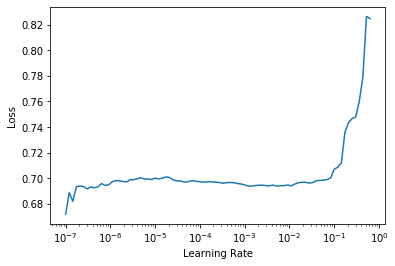

In [37]:
learn.lr_find()

In [38]:
learn.fit_one_cycle(30, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.694687,0.696473,0.521595,00:00
1,0.691518,0.698018,0.521595,00:00
2,0.691138,0.697027,0.521595,00:00
3,0.689763,0.695168,0.524917,00:00
4,0.687097,0.697653,0.518272,00:00
5,0.684706,0.705210,0.491694,00:00
6,0.683599,0.702775,0.501661,00:00
7,0.682241,0.710330,0.465116,00:00
8,0.679928,0.710407,0.485050,00:00
9,0.677598,0.711433,0.471761,00:00
